In [1]:
!pip3 install ipython-autotime

%load_ext autotime

## Análise dos dados

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('bank-full.csv',sep=';')
df.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,no


time: 109 ms


In [56]:
# Verificando campos nulos 
pd.options.mode.use_inf_as_na = True
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

time: 28.1 ms


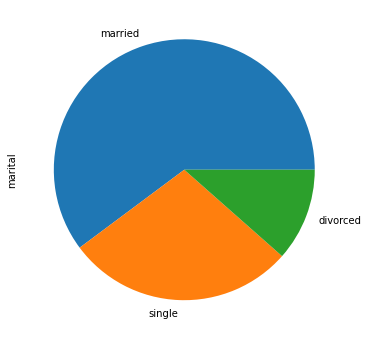

time: 76.5 ms


In [59]:
# Tamanho padrão das figuras
figsize=(10,6)

fig, ax = plt.subplots(1, 1, figsize=(figsize))
df.marital.value_counts().plot(kind='pie', ax=ax)

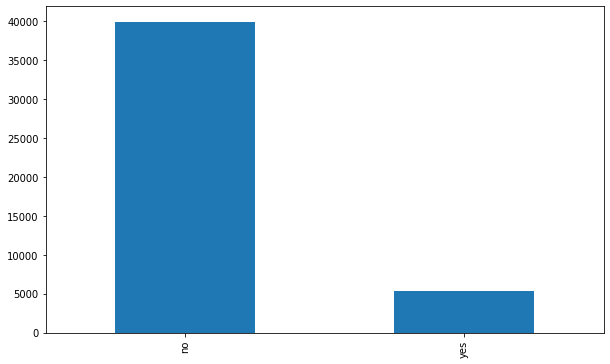

time: 173 ms


In [60]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
df.y.value_counts().plot(kind='bar', ax=ax)

In [57]:
# Tipos de dados

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB
time: 25 ms


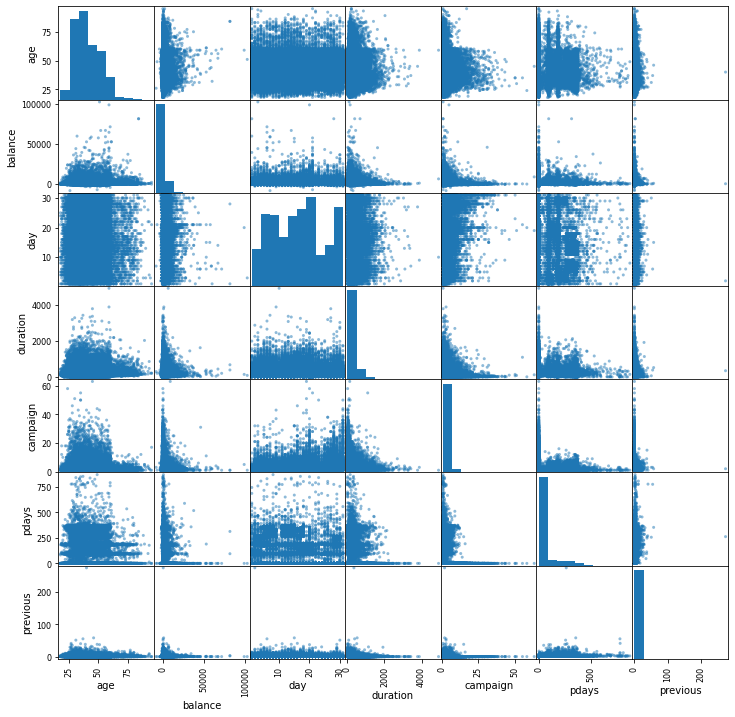

time: 10.2 s


In [58]:
pd.plotting.scatter_matrix(df[['age','balance','day','duration','campaign','pdays','previous']],figsize=(12, 12))
plt.show()

In [8]:
df['y'].value_counts()


no     39922
yes     5289
Name: y, dtype: int64

time: 20.8 ms


# Pré-processamento

In [85]:
from sklearn.impute          import SimpleImputer
from sklearn.preprocessing   import StandardScaler
from sklearn.preprocessing   import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline        import Pipeline
from sklearn.compose         import ColumnTransformer

# Renomeando coluna alvo 
df.rename(columns={'y': 'subscribed_term_deposit'}, inplace=True)
# Renomeando coluna default  
df.rename(columns={'default': 'credit_in_default'}, inplace=True)

# Transformando coluna default em uma única coluna binária
df['credit_in_default_bin'] = 0
df.loc[df['credit_in_default']=='yes','credit_in_default_bin'] = 1

# Transformando housing em uma única coluna binária
df['housing_bin'] = 0
df.loc[df['housing']=='yes','housing_bin'] = 1

# Transformando loan em uma única coluna binária
df['loan_bin'] = 0
df.loc[df['loan']=='yes','loan'] = 1

atributos_numericos = ['age','balance','day','duration','campaign','pdays','previous']
atributos_binarios  = ['credit_in_default_bin','housing_bin','loan_bin']
atributos_categoricos = ['job', 'marital','education', 'contact', 'month', 'poutcome']
nome_coluna_alvo = ['subscribed_term_deposit']

# separando os conjuntos de dados de treino e teste
df_treino, df_teste = train_test_split(df, test_size=0.2, random_state=42)

# separando a coluna alvo do conjunto de treino
df_treino_labels = df_treino[nome_coluna_alvo].copy()
df_treino        = df_treino.drop(columns=nome_coluna_alvo)

# separando a coluna alvo do conjunto de teste
df_teste_labels = df_teste[nome_coluna_alvo].copy()
df_teste        = df_teste.drop(columns=nome_coluna_alvo)


# Pipelines de Pré-processamento
pipeline_atr_numericos = Pipeline([
    ('imputer',SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
])

preproc_completo = ColumnTransformer([
    ('numericos',   pipeline_atr_numericos, atributos_numericos   ),
    ('binarios',    'passthrough',          atributos_binarios    ),
    ('categoricos', OneHotEncoder(),        atributos_categoricos ),
    ],
    sparse_threshold=0)

# pre-processamento do conjunto de treino
X_treino = preproc_completo.fit_transform(df_treino)

# pre-processamento do conjunto de teste
X_teste = preproc_completo.transform(df_teste)
    
# Coluna alvo para os conjuntos de treino e teste
y_treino = df_treino_labels[ nome_coluna_alvo ] == 'yes'
y_treino = y_treino.values.ravel()

y_teste  = df_teste_labels[  nome_coluna_alvo ] == 'yes'
y_teste  = y_teste.values.ravel()

nomes_atributos = atributos_numericos
nomes_atributos = np.append( nomes_atributos, atributos_binarios )
nomes_atributos = np.append( nomes_atributos,
                             preproc_completo.named_transformers_['categoricos'].get_feature_names())

time: 158 ms


In [86]:
X_treino.shape, y_treino.shape

((36168, 48), (36168,))

time: 2.13 ms


In [87]:
y_treino

array([False, False, False, ..., False, False, False])

time: 2.49 ms


In [88]:
valores_y_treino, quantidades_y_treino = np.unique(y_treino, return_counts=True)
print(np.asarray((valores_y_treino, quantidades_y_treino)))
print("Proporção classe True: ",quantidades_y_treino[1]/y_treino.shape[0])

[[    0     1]
 [31970  4198]]
Proporção classe True:  0.11606945366069453
time: 2.61 ms


In [89]:
X_teste.shape, y_teste.shape

((9043, 48), (9043,))

time: 2.75 ms


In [90]:
valores_y_teste, quantidades_y_teste = np.unique(y_teste, return_counts=True)
print(np.asarray((valores_y_teste, quantidades_y_teste)))
print("Proporção classe True: ",quantidades_y_teste[1]/y_teste.shape[0])

[[   0    1]
 [7952 1091]]
Proporção classe True:  0.1206458033838328
time: 2.13 ms


In [91]:
nomes_atributos

array(['age', 'balance', 'day', 'duration', 'campaign', 'pdays',
       'previous', 'credit_in_default_bin', 'housing_bin', 'loan_bin',
       'x0_admin.', 'x0_blue-collar', 'x0_entrepreneur', 'x0_housemaid',
       'x0_management', 'x0_retired', 'x0_self-employed', 'x0_services',
       'x0_student', 'x0_technician', 'x0_unemployed', 'x0_unknown',
       'x1_divorced', 'x1_married', 'x1_single', 'x2_primary',
       'x2_secondary', 'x2_tertiary', 'x2_unknown', 'x3_cellular',
       'x3_telephone', 'x3_unknown', 'x4_apr', 'x4_aug', 'x4_dec',
       'x4_feb', 'x4_jan', 'x4_jul', 'x4_jun', 'x4_mar', 'x4_may',
       'x4_nov', 'x4_oct', 'x4_sep', 'x5_failure', 'x5_other',
       'x5_success', 'x5_unknown'], dtype=object)

time: 2.71 ms


## Treinamento e avaliação de desempenho

In [92]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

time: 761 µs


### Regressão logística apenas para fins de comparação para os próximos passos

In [93]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_treino, y_treino)

y_previsto = log_reg.predict(X_teste)

print("Acurácia: ", accuracy_score(y_teste,y_previsto))
print("Precisão: ", precision_score(y_teste,y_previsto))
print("Recall:   ", recall_score(y_teste,y_previsto))
print("F1 Score: ", f1_score(y_teste,y_previsto))

Acurácia:  0.899037929890523
Precisão:  0.6539792387543253
Recall:    0.3464711274060495
F1 Score:  0.45296584781306176
time: 723 ms


## Treinamento de uma RNA tipo Multi-Layer Perceptron

In [94]:
from sklearn.neural_network import MLPClassifier

mlp_clf = MLPClassifier(hidden_layer_sizes=(20))
mlp_clf.fit(X_treino, y_treino)

y_previsto = mlp_clf.predict(X_teste)
print("MLP:")
print("Acurácia: ", accuracy_score(y_teste,y_previsto))
print("Precisão: ", precision_score(y_teste,y_previsto))
print("Recall:   ", recall_score(y_teste,y_previsto))
print("F1 Score: ", f1_score(y_teste,y_previsto))

MLP:
Acurácia:  0.906668141103616
Precisão:  0.6511627906976745
Recall:    0.48762603116406966
F1 Score:  0.5576519916142558
time: 27.7 s


## Testando diferentes RNA's usando MLP 

Utilizamos a técnica de GridSearchCV que foi ensinada em aula para fazer a descoberta da melhor arquitetura das redes escolhidas. Como nosso dataset possui poucas colunas e como pode ser visto um pouco mais acima, foi gerado um modelo com apenas 48 colunas possíveis optamos por não colocar números muito distante desse valor. Apenas 1 teste foi feito com 100 neurônios para fim de comparação/curiosidade

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
 {'hidden_layer_sizes': [(10,), (20,), (20,20), (50,50), (50,20), (100,100), (30,30,30) ], 
  'activation': ['logistic', 'tanh', 'relu']},
 ]

mlp_clf = MLPClassifier()

grid_search = GridSearchCV(mlp_clf, param_grid)
grid_search.fit(X_treino, y_treino)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=None, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=None, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_gr

time: 1h 12min 38s


In [ ]:
grid_search.best_params_

{'activation': 'logistic', 'hidden_layer_sizes': (20,)}

time: 2.64 ms


### Avaliando modelo com os melhores parametros de saida do GridSearch

In [ ]:
y_previsto = grid_search.best_estimator_.predict(X_teste)
print("Best MLP:")
print("Acurácia: ", accuracy_score(y_teste,y_previsto))
print("Precisão: ", precision_score(y_teste,y_previsto))
print("Recall:   ", recall_score(y_teste,y_previsto))
print("F1 Score: ", f1_score(y_teste,y_previsto))

Best MLP:
Acurácia:  0.9091009620701095
Precisão:  0.6530147895335608
Recall:    0.5261228230980751
F1 Score:  0.582741116751269
time: 36.7 ms


## Treinamento usando Keras + TensorFlow

In [95]:
import tensorflow as tf
from tensorflow import keras
tf.__version__, keras.__version__

('2.2.0', '2.3.0-tf')

time: 4.47 ms


In [96]:
X_treino.shape[1:]

(48,)

time: 2.72 ms


### Construindo o modelo a ser treinado

In [97]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(20, activation="relu",input_shape=X_treino.shape[1:]))
model.add(keras.layers.Dense(20, activation="relu"))
model.add(keras.layers.Dense(2, activation="softmax"))

time: 45.3 ms


In [98]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 20)                980       
_________________________________________________________________
dense_4 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 42        
Total params: 1,442
Trainable params: 1,442
Non-trainable params: 0
_________________________________________________________________
time: 1.43 ms


In [99]:
# Para modelos de classificação com saída esparsa:    # para classificação com saída densa  # para classificação binária:     
model.compile(loss="sparse_categorical_crossentropy", # usar categorical_crossentropy       # usar binary_crossentropy e mudar
              optimizer="sgd",                        #                                     # a ativação da camada de saída
              metrics=["accuracy"])                   #                                     # para sigmoid

# Para modelos de regressão deixar a última camada com um
# único neurônio sem ativação e usar loss="mean_squared_error"



time: 10.3 ms


### Treinando o modelo

In [100]:
history = model.fit(X_treino, y_treino, epochs=10, validation_split=0.2)

Epoch 1/10
905/905 [==============================] - 2s 2ms/step - loss: 0.3042 - accuracy: 0.8852 - val_loss: 0.2575 - val_accuracy: 0.8905
Epoch 2/10
905/905 [==============================] - 1s 1ms/step - loss: 0.2506 - accuracy: 0.8935 - val_loss: 0.2378 - val_accuracy: 0.8967
Epoch 3/10
905/905 [==============================] - 1s 1ms/step - loss: 0.2378 - accuracy: 0.8965 - val_loss: 0.2310 - val_accuracy: 0.8949
Epoch 4/10
905/905 [==============================] - 1s 1ms/step - loss: 0.2312 - accuracy: 0.8984 - val_loss: 0.2262 - val_accuracy: 0.8980
Epoch 5/10
905/905 [==============================] - 1s 1ms/step - loss: 0.2270 - accuracy: 0.9005 - val_loss: 0.2232 - val_accuracy: 0.8994
Epoch 6/10
905/905 [==============================] - 1s 1ms/step - loss: 0.2244 - accuracy: 0.9010 - val_loss: 0.2222 - val_accuracy: 0.8988
Epoch 7/10
905/905 [==============================] - 1s 1ms/step - loss: 0.2223 - accuracy: 0.9018 - val_loss: 0.2209 - val_accuracy: 0.8978
Epoch 

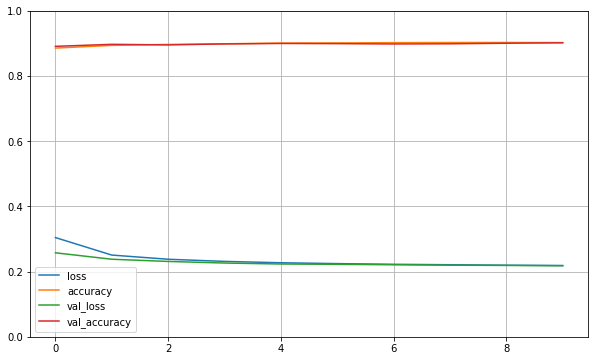

time: 190 ms


In [101]:
pd.DataFrame(history.history).plot(figsize=(10,6))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

### Avaliando o desempenho do modelo treinado

In [102]:
y_previsto_rna_proba = model.predict(X_teste)

time: 265 ms


In [103]:
np.round(y_previsto_rna_proba,decimals=2)

array([[1.  , 0.  ],
       [1.  , 0.  ],
       [0.66, 0.34],
       ...,
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.98, 0.02]], dtype=float32)

time: 6.12 ms


In [104]:
y_previsto_rna = model.predict_classes(X_teste)
y_previsto_rna

array([0, 0, 0, ..., 0, 0, 0])

time: 136 ms


In [105]:
print("RNA:")
print("Acurácia: ", accuracy_score(y_teste,y_previsto_rna))
print("Precisão: ", precision_score(y_teste,y_previsto_rna))
print("Recall:   ", recall_score(y_teste,y_previsto_rna))
print("F1 Score: ", f1_score(y_teste,y_previsto_rna))

RNA:
Acurácia:  0.8987061815769103
Precisão:  0.6251788268955651
Recall:    0.4005499541704858
F1 Score:  0.48826815642458105
time: 17.7 ms


### Early Stopping

Aplicamos a técinca ensinada em aula para procurar o melhor modelo e faer que o algoritmo pare de executar assim que não detectar nenhuma melhora significativa. 

Epoch 1/100
905/905 [==============================] - 2s 2ms/step - loss: 0.2997 - accuracy: 0.8843 - val_loss: 0.2464 - val_accuracy: 0.8900
Epoch 2/100
905/905 [==============================] - 1s 2ms/step - loss: 0.2415 - accuracy: 0.8934 - val_loss: 0.2320 - val_accuracy: 0.9017
Epoch 3/100
905/905 [==============================] - 1s 1ms/step - loss: 0.2307 - accuracy: 0.8995 - val_loss: 0.2254 - val_accuracy: 0.9024
Epoch 4/100
905/905 [==============================] - 1s 1ms/step - loss: 0.2250 - accuracy: 0.9010 - val_loss: 0.2216 - val_accuracy: 0.9032
Epoch 5/100
905/905 [==============================] - 1s 2ms/step - loss: 0.2215 - accuracy: 0.9025 - val_loss: 0.2186 - val_accuracy: 0.9030
Epoch 6/100
905/905 [==============================] - 1s 2ms/step - loss: 0.2185 - accuracy: 0.9027 - val_loss: 0.2166 - val_accuracy: 0.9070
Epoch 7/100
905/905 [==============================] - 1s 1ms/step - loss: 0.2164 - accuracy: 0.9034 - val_loss: 0.2162 - val_accuracy: 0.9063

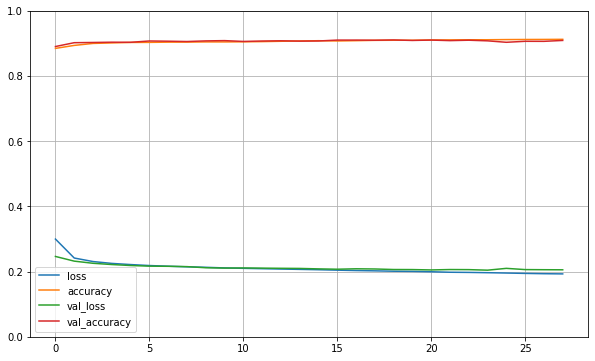

time: 41.2 s


In [106]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(80, activation="relu",input_shape=X_treino.shape[1:]))
model.add(keras.layers.Dense(30, activation="relu"))
model.add(keras.layers.Dense(10, activation="relu"))
model.add(keras.layers.Dense(2, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
                optimizer="sgd",
                metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=4,restore_best_weights=True)

history = model.fit(X_treino, y_treino, epochs=100, validation_split=0.2,callbacks=[early_stopping_cb])

print("RNA:")
print("Acurácia: ", accuracy_score(y_teste,y_previsto_rna))
print("Precisão: ", precision_score(y_teste,y_previsto_rna))
print("Recall:   ", recall_score(y_teste,y_previsto_rna))
print("F1 Score: ", f1_score(y_teste,y_previsto_rna))

pd.DataFrame(history.history).plot(figsize=(10,6))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

### Grid Search


In [250]:
def MLPKerasTF(hidden_layer_sizes=(20),activation="relu"):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=X_treino.shape[1:]))
    for units in hidden_layer_sizes:
        model.add(keras.layers.Dense(units,activation=activation))
    model.add(keras.layers.Dense(2, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])
    model.summary()
    print("activation=",activation)
    return model

mlpKerasTF_clf = keras.wrappers.scikit_learn.KerasClassifier(MLPKerasTF)

time: 1.27 ms


In [251]:
from sklearn.model_selection import GridSearchCV

param_grid = [
 {'hidden_layer_sizes':[(10,), (20,), (20,20), (50,50), (20,10,5), (40,20,5), (100,50,10)],
  'activation': ['sigmoid', 'tanh', 'relu']},
 ]

grid_search = GridSearchCV(mlpKerasTF_clf, param_grid)
grid_search.fit(X_treino, y_treino, epochs=10)

Model: "sequential_938"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3119 (Dense)           (None, 10)                490       
_________________________________________________________________
dense_3120 (Dense)           (None, 2)                 22        
Total params: 512
Trainable params: 512
Non-trainable params: 0
_________________________________________________________________
activation= sigmoid
Epoch 1/10
905/905 [==============================] - 1s 1ms/step - loss: 0.3591 - accuracy: 0.8825
Epoch 2/10
905/905 [==============================] - 1s 1ms/step - loss: 0.3211 - accuracy: 0.8827
Epoch 3/10
905/905 [==============================] - 1s 1ms/step - loss: 0.2992 - accuracy: 0.8840
Epoch 4/10
905/905 [==============================] - 2s 2ms/step - loss: 0.2837 - accuracy: 0.8867
Epoch 5/10
905/905 [==============================] - 2s 2ms/step - loss: 0.2734 - accuracy: 0.8

905/905 [==============================] - 1s 2ms/step - loss: 0.3067 - accuracy: 0.8848
Epoch 3/10
905/905 [==============================] - 1s 2ms/step - loss: 0.2831 - accuracy: 0.8870
Epoch 4/10
905/905 [==============================] - 1s 2ms/step - loss: 0.2696 - accuracy: 0.8900
Epoch 5/10
905/905 [==============================] - 1s 2ms/step - loss: 0.2619 - accuracy: 0.8918
Epoch 6/10
905/905 [==============================] - 1s 2ms/step - loss: 0.2570 - accuracy: 0.8928
Epoch 7/10
905/905 [==============================] - 1s 2ms/step - loss: 0.2536 - accuracy: 0.8934
Epoch 8/10
905/905 [==============================] - 1s 2ms/step - loss: 0.2509 - accuracy: 0.8945
Epoch 9/10
905/905 [==============================] - 1s 2ms/step - loss: 0.2486 - accuracy: 0.8952
Epoch 10/10
227/227 [==============================] - 0s 1ms/step - loss: 0.2421 - accuracy: 0.9000
Model: "sequential_948"
_________________________________________________________________
Layer (type)        

Epoch 1/10
905/905 [==============================] - 1s 2ms/step - loss: 0.3530 - accuracy: 0.8833
Epoch 2/10
905/905 [==============================] - 1s 2ms/step - loss: 0.3442 - accuracy: 0.8833
Epoch 3/10
905/905 [==============================] - 2s 2ms/step - loss: 0.3351 - accuracy: 0.8833
Epoch 4/10
905/905 [==============================] - 1s 2ms/step - loss: 0.3234 - accuracy: 0.8833
Epoch 5/10
905/905 [==============================] - 1s 2ms/step - loss: 0.3094 - accuracy: 0.8833
Epoch 6/10
905/905 [==============================] - 1s 2ms/step - loss: 0.2948 - accuracy: 0.8842
Epoch 7/10
905/905 [==============================] - 2s 2ms/step - loss: 0.2822 - accuracy: 0.8866
Epoch 8/10
905/905 [==============================] - 1s 2ms/step - loss: 0.2730 - accuracy: 0.8897
Epoch 9/10
905/905 [==============================] - 1s 2ms/step - loss: 0.2664 - accuracy: 0.8910
Epoch 10/10
227/227 [==============================] - 0s 2ms/step - loss: 0.2539 - accuracy: 0.8971

905/905 [==============================] - 2s 2ms/step - loss: 0.3537 - accuracy: 0.8858
Epoch 7/10
905/905 [==============================] - 2s 2ms/step - loss: 0.3534 - accuracy: 0.8858
Epoch 8/10
905/905 [==============================] - 2s 2ms/step - loss: 0.3530 - accuracy: 0.8858
Epoch 9/10
905/905 [==============================] - 2s 2ms/step - loss: 0.3527 - accuracy: 0.8858
Epoch 10/10
227/227 [==============================] - 0s 1ms/step - loss: 0.3715 - accuracy: 0.8764
Model: "sequential_965"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3197 (Dense)           (None, 40)                1960      
_________________________________________________________________
dense_3198 (Dense)           (None, 20)                820       
_________________________________________________________________
dense_3199 (Dense)           (None, 5)                 105       
________________________

227/227 [==============================] - 0s 2ms/step - loss: 0.3552 - accuracy: 0.8825
Model: "sequential_973"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3229 (Dense)           (None, 10)                490       
_________________________________________________________________
dense_3230 (Dense)           (None, 2)                 22        
Total params: 512
Trainable params: 512
Non-trainable params: 0
_________________________________________________________________
activation= tanh
Epoch 1/10
905/905 [==============================] - 1s 2ms/step - loss: 0.3140 - accuracy: 0.8753
Epoch 2/10
905/905 [==============================] - 1s 2ms/step - loss: 0.2603 - accuracy: 0.8942
Epoch 3/10
905/905 [==============================] - 1s 2ms/step - loss: 0.2493 - accuracy: 0.8976
Epoch 4/10
905/905 [==============================] - 1s 2ms/step - loss: 0.2418 - accuracy: 0.8993
Epoch 5/10

Epoch 1/10
905/905 [==============================] - 1s 2ms/step - loss: 0.3115 - accuracy: 0.8733
Epoch 2/10
905/905 [==============================] - 1s 2ms/step - loss: 0.2576 - accuracy: 0.8929
Epoch 3/10
905/905 [==============================] - 1s 2ms/step - loss: 0.2470 - accuracy: 0.8974
Epoch 4/10
905/905 [==============================] - 1s 2ms/step - loss: 0.2402 - accuracy: 0.8991
Epoch 5/10
905/905 [==============================] - 1s 2ms/step - loss: 0.2356 - accuracy: 0.9005
Epoch 6/10
905/905 [==============================] - 1s 2ms/step - loss: 0.2323 - accuracy: 0.9008
Epoch 7/10
905/905 [==============================] - 1s 2ms/step - loss: 0.2300 - accuracy: 0.9012
Epoch 8/10
905/905 [==============================] - 1s 2ms/step - loss: 0.2280 - accuracy: 0.9014
Epoch 9/10
905/905 [==============================] - 1s 2ms/step - loss: 0.2265 - accuracy: 0.9024
Epoch 10/10
227/227 [==============================] - 0s 1ms/step - loss: 0.2208 - accuracy: 0.9020

Epoch 1/10
905/905 [==============================] - 1s 2ms/step - loss: 0.2726 - accuracy: 0.8894
Epoch 2/10
905/905 [==============================] - 2s 2ms/step - loss: 0.2423 - accuracy: 0.8963
Epoch 3/10
905/905 [==============================] - 1s 2ms/step - loss: 0.2331 - accuracy: 0.9001
Epoch 4/10
905/905 [==============================] - 1s 2ms/step - loss: 0.2280 - accuracy: 0.9007
Epoch 5/10
905/905 [==============================] - 1s 2ms/step - loss: 0.2253 - accuracy: 0.9018
Epoch 6/10
905/905 [==============================] - 2s 2ms/step - loss: 0.2234 - accuracy: 0.9031
Epoch 7/10
905/905 [==============================] - 2s 2ms/step - loss: 0.2218 - accuracy: 0.9028
Epoch 8/10
905/905 [==============================] - 2s 2ms/step - loss: 0.2210 - accuracy: 0.9022
Epoch 9/10
905/905 [==============================] - 1s 2ms/step - loss: 0.2200 - accuracy: 0.9036
Epoch 10/10
227/227 [==============================] - 0s 1ms/step - loss: 0.2215 - accuracy: 0.9057

905/905 [==============================] - ETA: 0s - loss: 0.2203 - accuracy: 0.90 - 1s 2ms/step - loss: 0.2200 - accuracy: 0.9030
Epoch 7/10
905/905 [==============================] - 2s 2ms/step - loss: 0.2183 - accuracy: 0.9040
Epoch 8/10
905/905 [==============================] - 2s 2ms/step - loss: 0.2166 - accuracy: 0.9043
Epoch 9/10
905/905 [==============================] - 1s 2ms/step - loss: 0.2156 - accuracy: 0.9053
Epoch 10/10
227/227 [==============================] - 0s 1ms/step - loss: 0.2273 - accuracy: 0.9002
Model: "sequential_1000"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3307 (Dense)           (None, 40)                1960      
_________________________________________________________________
dense_3308 (Dense)           (None, 20)                820       
_________________________________________________________________
dense_3309 (Dense)           (None, 5)         

905/905 [==============================] - 2s 2ms/step - loss: 0.2170 - accuracy: 0.9051
Epoch 10/10
227/227 [==============================] - 0s 2ms/step - loss: 0.2153 - accuracy: 0.9020
Model: "sequential_1008"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3339 (Dense)           (None, 10)                490       
_________________________________________________________________
dense_3340 (Dense)           (None, 2)                 22        
Total params: 512
Trainable params: 512
Non-trainable params: 0
_________________________________________________________________
activation= relu
Epoch 1/10
905/905 [==============================] - 1s 2ms/step - loss: 0.3291 - accuracy: 0.8740
Epoch 2/10
905/905 [==============================] - 1s 2ms/step - loss: 0.2649 - accuracy: 0.8904
Epoch 3/10
905/905 [==============================] - 2s 2ms/step - loss: 0.2504 - accuracy: 0.8934
Epoch 4/

Epoch 1/10
905/905 [==============================] - 1s 2ms/step - loss: 0.3017 - accuracy: 0.8851
Epoch 2/10
905/905 [==============================] - 1s 2ms/step - loss: 0.2488 - accuracy: 0.8946
Epoch 3/10
905/905 [==============================] - 1s 2ms/step - loss: 0.2380 - accuracy: 0.8988
Epoch 4/10
905/905 [==============================] - 1s 2ms/step - loss: 0.2324 - accuracy: 0.8997
Epoch 5/10
905/905 [==============================] - 1s 2ms/step - loss: 0.2289 - accuracy: 0.9016
Epoch 6/10
905/905 [==============================] - 1s 2ms/step - loss: 0.2262 - accuracy: 0.9020
Epoch 7/10
905/905 [==============================] - 1s 2ms/step - loss: 0.2242 - accuracy: 0.9025
Epoch 8/10
905/905 [==============================] - 1s 2ms/step - loss: 0.2225 - accuracy: 0.9037
Epoch 9/10
905/905 [==============================] - 1s 2ms/step - loss: 0.2212 - accuracy: 0.9031
Epoch 10/10
227/227 [==============================] - 0s 2ms/step - loss: 0.2199 - accuracy: 0.9018

Epoch 1/10
905/905 [==============================] - 1s 2ms/step - loss: 0.2936 - accuracy: 0.8822
Epoch 2/10
905/905 [==============================] - 1s 2ms/step - loss: 0.2431 - accuracy: 0.8945
Epoch 3/10
905/905 [==============================] - 2s 2ms/step - loss: 0.2326 - accuracy: 0.8981
Epoch 4/10
905/905 [==============================] - 2s 2ms/step - loss: 0.2264 - accuracy: 0.9008
Epoch 5/10
905/905 [==============================] - 2s 2ms/step - loss: 0.2225 - accuracy: 0.9024
Epoch 6/10
905/905 [==============================] - 2s 2ms/step - loss: 0.2200 - accuracy: 0.9030
Epoch 7/10
905/905 [==============================] - 2s 2ms/step - loss: 0.2177 - accuracy: 0.9034
Epoch 8/10
905/905 [==============================] - 2s 2ms/step - loss: 0.2160 - accuracy: 0.9043
Epoch 9/10
905/905 [==============================] - 1s 2ms/step - loss: 0.2144 - accuracy: 0.9049
Epoch 10/10
227/227 [==============================] - 0s 1ms/step - loss: 0.2168 - accuracy: 0.9020

905/905 [==============================] - 2s 2ms/step - loss: 0.2194 - accuracy: 0.9016
Epoch 7/10
905/905 [==============================] - 2s 2ms/step - loss: 0.2170 - accuracy: 0.9026
Epoch 8/10
905/905 [==============================] - 2s 2ms/step - loss: 0.2154 - accuracy: 0.9034
Epoch 9/10
905/905 [==============================] - 2s 2ms/step - loss: 0.2140 - accuracy: 0.9052
Epoch 10/10
227/227 [==============================] - 0s 1ms/step - loss: 0.2310 - accuracy: 0.8978
Model: "sequential_1035"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3417 (Dense)           (None, 40)                1960      
_________________________________________________________________
dense_3418 (Dense)           (None, 20)                820       
_________________________________________________________________
dense_3419 (Dense)           (None, 5)                 105       
_______________________

227/227 [==============================] - 0s 2ms/step - loss: 0.2135 - accuracy: 0.9039
Model: "sequential_1043"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3449 (Dense)           (None, 100)               4900      
_________________________________________________________________
dense_3450 (Dense)           (None, 50)                5050      
_________________________________________________________________
dense_3451 (Dense)           (None, 10)                510       
_________________________________________________________________
dense_3452 (Dense)           (None, 2)                 22        
Total params: 10,482
Trainable params: 10,482
Non-trainable params: 0
_________________________________________________________________
activation= tanh
Epoch 1/10
1131/1131 [==============================] - 2s 2ms/step - loss: 0.2612 - accuracy: 0.8933
Epoch 2/10
1131/1131 [===============

GridSearchCV(estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7faecf045af0>,
             param_grid=[{'activation': ['sigmoid', 'tanh', 'relu'],
                          'hidden_layer_sizes': [(10,), (20,), (20, 20),
                                                 (50, 50), (20, 10, 5),
                                                 (40, 20, 5), (100, 50, 10)]}])

time: 29min 54s


In [253]:
grid_search.best_params_

{'activation': 'tanh', 'hidden_layer_sizes': (100, 50, 10)}

time: 6.01 ms


In [254]:
y_previsto = grid_search.best_estimator_.predict(X_teste)
print("Best MLPKerasTF:")
print("Acurácia: ", accuracy_score(y_teste,y_previsto))
print("Precisão: ", precision_score(y_teste,y_previsto))
print("Recall:   ", recall_score(y_teste,y_previsto))
print("F1 Score: ", f1_score(y_teste,y_previsto))

Best MLPKerasTF:
Acurácia:  0.9046776512219397
Precisão:  0.6512549537648613
Recall:    0.45187901008249315
F1 Score:  0.5335497835497836
time: 258 ms


## Criando um modelo complexo

In [255]:
# construção de um modelo Deep & Wide
# para mais informações: https://arxiv.org/abs/1606.07792

input_  = keras.layers.Input(shape=X_treino.shape[1:])
hidden1 = keras.layers.Dense(100,activation="tanh")(input_)
hidden2 = keras.layers.Dense(50,activation="tanh")(hidden1)
hidden3 = keras.layers.Dense(10,activation="tanh")(hidden2)
concat  = keras.layers.Concatenate()([input_,hidden3])
output  = keras.layers.Dense(1,activation="sigmoid")(concat)
modelDW   = keras.Model(inputs=[input_],outputs=[output])

modelDW.compile(loss="binary_crossentropy",
                optimizer="sgd",
                metrics=["accuracy"])

time: 109 ms


In [256]:
import os
import time

run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
root_logdir = os.path.join(os.curdir,"logs")
run_logdir = os.path.join(root_logdir,run_id)
print("logdir = ",run_logdir)

# para salvar os logs necessários ao uso do TensorBoard
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

# para forçar o treinamento a parar antecipadamente quando não houver progresso na minimização de erro
early_stopping_cb = keras.callbacks.EarlyStopping(patience=4,restore_best_weights=True)

# para alvar periodicamente o modelo treinado e poder recomeçar o treinamento em caso de pane no meio do treinamento
checkpoint_cb     = keras.callbacks.ModelCheckpoint("model-BankMarketingData.h5") # Arquivo formato HDF5

history = modelDW.fit(X_treino, 
                      y_treino, 
                      epochs=200, 
                      validation_split=0.2,
                      callbacks=[early_stopping_cb, 
                                 checkpoint_cb,
                                 tensorboard_cb])

# para acompanhar o treinamento pelo TensorBoar:
# 1 - Rodar no console o seguinte comando dentro do diretorio do projeto: tensorboard --logdir=.\logs --port=6006
# 2 - Depois abrir a seguinte página em outra aba do navegador: http://localhost:6006/

# Pode ser usado o seguinte método para salvar manualmente um modelo:
# modelDW.save("modelDW-AcidentesTransitoPOA.h5")

# Pode ser usado o seguinte método para recuperação do modelo treinado:
# modelDW = keras.models.load_model("modelDW-AcidentesTransitoPOA.h5")

logdir =  ./logs/run_2020_06_27-17_59_14
Epoch 1/200
905/905 [==============================] - 6s 6ms/step - loss: 0.3026 - accuracy: 0.8856 - val_loss: 0.2539 - val_accuracy: 0.8991
Epoch 2/200
905/905 [==============================] - 3s 3ms/step - loss: 0.2500 - accuracy: 0.8960 - val_loss: 0.2399 - val_accuracy: 0.8999
Epoch 3/200
905/905 [==============================] - 3s 3ms/step - loss: 0.2389 - accuracy: 0.8983 - val_loss: 0.2324 - val_accuracy: 0.9021
Epoch 4/200
905/905 [==============================] - 3s 3ms/step - loss: 0.2324 - accuracy: 0.9003 - val_loss: 0.2267 - val_accuracy: 0.9024
Epoch 5/200
905/905 [==============================] - 3s 3ms/step - loss: 0.2282 - accuracy: 0.9012 - val_loss: 0.2235 - val_accuracy: 0.9038
Epoch 6/200
905/905 [==============================] - 3s 3ms/step - loss: 0.2256 - accuracy: 0.9019 - val_loss: 0.2213 - val_accuracy: 0.9032
Epoch 7/200
905/905 [==============================] - 3s 3ms/step - loss: 0.2239 - accuracy: 0.9021 

In [257]:
y_previsto_rna_proba = modelDW.predict(X_teste)
y_previsto_rna_proba

array([[0.00036046],
       [0.00206521],
       [0.19134206],
       ...,
       [0.00196322],
       [0.00051588],
       [0.0022231 ]], dtype=float32)

time: 238 ms


In [258]:
y_previsto_rna = y_previsto_rna_proba > 0.5
y_previsto_rna

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

time: 6.41 ms


In [259]:
print("RNA D&W:")
print("Acurácia: ", accuracy_score(y_teste,y_previsto_rna))
print("Precisão: ", precision_score(y_teste,y_previsto_rna))
print("Recall:   ", recall_score(y_teste,y_previsto_rna))
print("F1 Score: ", f1_score(y_teste,y_previsto_rna))

RNA D&W:
Acurácia:  0.9045670684507354
Precisão:  0.636038186157518
Recall:    0.48854262144821264
F1 Score:  0.5526179367547953
time: 33.4 ms
